# Results from WandB


## Imports

In [1]:
import wandb
from community.utils.wandb_utils import get_wandb_artifact, get_wandb_runs
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd
import numpy.linalg as LA

## Load Results

In [2]:
sweep_path = "gbena/funcspec/mjw4dzu9"
sweep_path = "m2snn/funcspec_V2/lf31u7wy"
sweep_path = "m2snn/funcspec_V2/etsyghun"
sweep_path = "m2snn/funcspec_V2/y1n0vtbp"
sweep_path = "m2snn/funcspec_V2/if1h3qpo"
sweep_path = "m2snn/funcspec_V2/o90n8wvw"
sweep_path = "m2snn/funcspec_V2/t3avf3g4"
sweep_path = "m2snn/funcspec_V2/0cwq0u1o"
sweep_path = "m2snn/funcspec_V2/1irwkxuo"


sweep_id = sweep_path.split("/")[-1]

total_data = pd.read_pickle(f"../../results/sweep_tables/{sweep_id}")
total_data.columns, total_data.shape

(Index(['Step', 'best_acc', 'common_input', 'common_readout', 'n_hidden',
        'sparsity', 'task', 'bottleneck_det', 'bottleneck_det_col_norm',
        'bottleneck_norm_1', 'bottleneck_norm_2', 'bottleneck_norm_fro',
        'bottleneck_norm_nuc', 'bottleneck_global_diff', 'name'],
       dtype='object'),
 (79420, 15))

In [3]:
def filter_data(data, key, value):
    if value is None:
        return data[data[key].isnull()]
    else:
        return data[data[key] == value]

steps = ['mid-', 'last'] 
tasks = ["all", 'parity-both']
varying_params = [{"common_readout": [True, False]}, {"common_input": [True, False]}]

try : 
    f_data = [[filter_data(filter_data(total_data, 'Step', s), "task", t) for s in steps] for t in tasks]
except KeyError : 
    f_data = [filter_data(total_data, 'Step', s) for s in steps]


In [4]:
[[f['bottleneck_global_diff'].mean() for f in f_d] for f_d in f_data]

[[0.1916189071318072, 0.16549806016453808],
 [0.07241833213422168, 0.033633780983768284]]

In [5]:
def get_values(data, value="bottleneck_global_diff") : 
    return data[["n_hidden", "sparsity", value]].values.T

## Plot Smooth Heatmap

In [6]:
from community.utils.heatmap import compute_and_plot_heatmap, compute_and_plot_colormesh

### heatmap

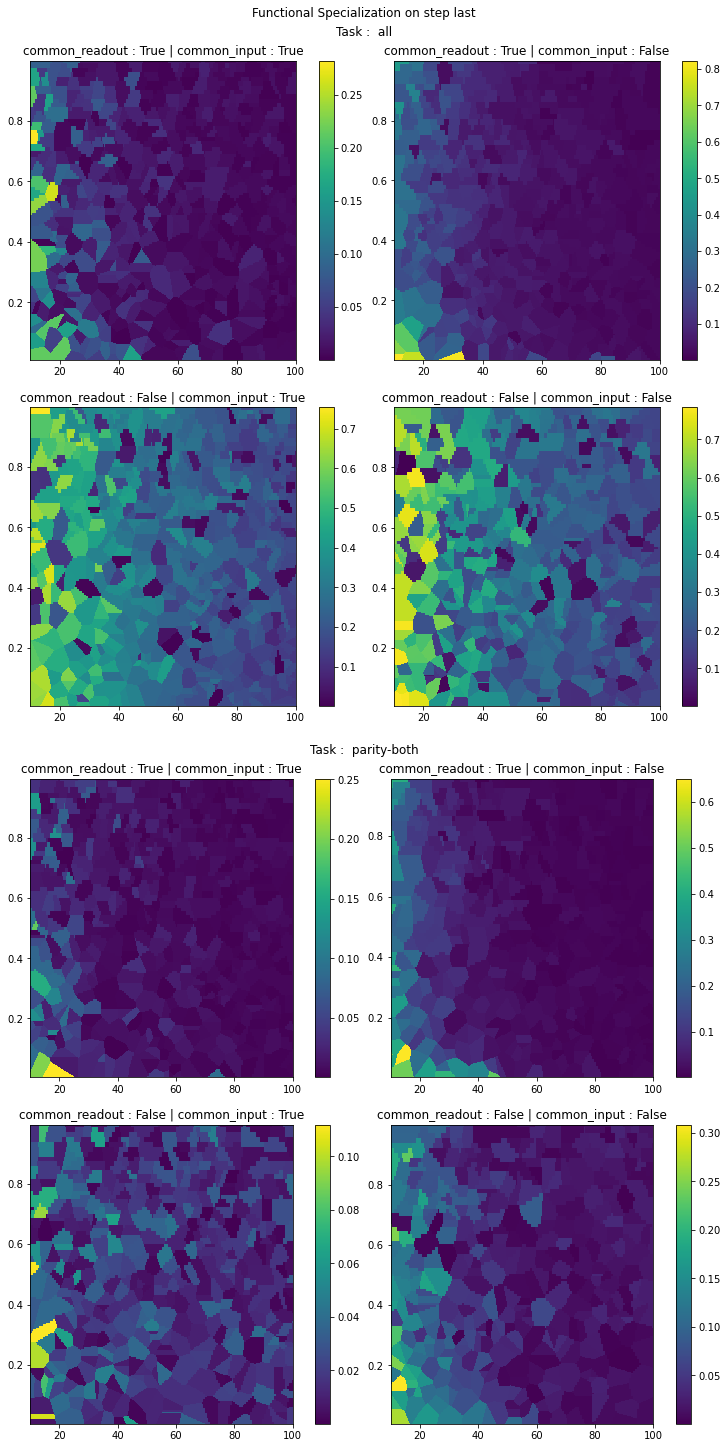

In [7]:
type = 'scipy'

n_tasks = len(tasks)
n_steps = len(steps)

color = 'bottleneck_global_diff'
#color = 'best_acc'

for step in ['last'] :

    s = steps.index(step) 
        
    (n1, v_p1), (n2, v_p2) = (tuple(*v.items()) for v in varying_params)


    fig = plt.figure(
        constrained_layout=True, figsize=(5 * len(v_p1), 5 * n_steps * len(v_p2))
    )
    fig.suptitle(f"Functional Specialization on step {step}")

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=n_tasks, ncols=1)
    if len(f_data) == 1:
        subfigs = [subfigs]

    Zs = []

    for t, (subfig, task) in enumerate(zip(subfigs, tasks)):

        #subfig.suptitle(f"Task :  {task}")
        subfig.suptitle(f"Task :  {task}")

        # create subplots per subfig

        axs = subfig.subplots(nrows=len(v_p1), ncols=len(v_p2))

        # t_values = task_values[task].copy()
        # norm_values = normalized_values[task]

        for i, v1 in enumerate(v_p1):
            for j, v2 in enumerate(v_p2):

                try:
                    ax = axs[i, j]
                except IndexError:
                    ax = axs[i + j]

                #minmax = (
                #    f_data[t][s]["bottleneck_global_diff"].min(),
                #    f_data[t][s]["bottleneck_global_diff"].max(),
                #)

                data = filter_data(filter_data(f_data[t][s], n1, v1), n2, v2)
                argmins = (
                    data[color].values.argsort()[:10],
                    data[color].values.argsort()[-10:],
                )
                minmax = [data[color].values[idxs].mean() for idxs in argmins]
                #print(minmax)
                #print(data.shape)
                values = get_values(data, color)

                if 0 not in data.shape : 
                    if type == 'heatmap' : 
                            
                        (X, Y), (X_mesh, Y_mesh), Z, sigmas, *_ = compute_and_plot_heatmap(
                            values,
                            (fig, ax),
                            log_scale=True,
                            plot_f=False,
                            random=False,
                            minmax=minmax
                        )
                    elif type == 'scipy' : 
                        X_mesh, Y_mesh, Z, (fig, ax), cbar = compute_and_plot_colormesh(values, (fig, ax))

                    Zs.append(Z)

                ax.set_title(f"{n1} : {v1} | {n2} : {v2}")

# Find new metric

In [2]:
import numpy as np
import numpy.linalg as LA
from numpy.linalg import LinAlgError


In [8]:
def agent_diff(col):
    return (col[1] - col[0]) / col.sum()


def global_diff(M):
    return np.abs(agent_diff(M[:, 0]) - agent_diff(M[:, 1])) / 2


def new_metric(M):
    return np.abs(LA.det(M)) / M.sum(0).prod()

In [29]:
n_agents = 2

M = np.random.rand(n_agents, n_agents)

M = np.eye(n_agents)
M[0, 1] = 1

new_metric(M), np.abs(LA.det(M))


(0.5, 1.0)

In [128]:
idxs = [0, 2]
sub_mat = lambda M, idx: np.delete(np.delete(M, idx[0], 0), idx[1], 1).squeeze()
sub_mat(M, idxs), M

(array([[0., 1.],
        [0., 0.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [180]:
def reccursive_new_metric(M):
    if M.shape[0] > 2:

        res = new_metric(M)

        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                subM = sub_mat(M, [i, j])
                res += reccursive_new_metric(subM)

    else:
        res = new_metric(M)

    print(res)
    return res